In [5]:
import pandas as pd

# Change path to your file
EXCEL_PATH = "C:\\Users\\Aman Bisen\\Desktop\\flipkart_12.xlsx"

# Load the Excel file (shows sheets if multiple)
xls = pd.ExcelFile(EXCEL_PATH, engine='openpyxl')
print("Sheets:", xls.sheet_names)

# Load the first sheet by default; change sheet_name if needed
df = pd.read_excel(EXCEL_PATH, sheet_name=xls.sheet_names[0], engine='openpyxl')

# Display first 10 rows and shape of the dataframe
print(df.head(10))
print("Shape of DataFrame:", df.shape)


Sheets: ['Data']
   Unnamed: 0                                            caption  \
0         NaN  Don’t go far hunting for Apple deals.✨Flipkart...   
1         NaN  Ye Big Billion Days hai, yahan kuch bhi ho sak...   
2         NaN  Naam Dilayega Inaam. Make your BGMI name your ...   
3         NaN  It’s that time of the year, jab Flipkart Big B...   
4         NaN  24 hour early access for Flipkart Plus & Black...   
5         NaN  1 phone, 2 phone, old phone, new phone!\nA Big...   
6         NaN  24 Hour early access for Flipkart Plus & Black...   
7         NaN  All all the Korean Beauty products, iPhones an...   
8         NaN  Ab toh laundry bhi hogi legendary!\nA Big Bill...   
9         NaN  Keep adding to cart and we’ll keep dropping th...   

                                    childPosts/0/alt  childPosts/0/caption  \
0                                                NaN                   NaN   
1  Photo by Flipkart on September 20, 2025. May b...                   NaN   


In [10]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

def preprocess_caption(file_path, caption_column_name='caption', output_file_name='preprocessed_caption.xlsx'):
    """
    Preprocess only the caption column for text analysis.
    """
    try:
        # Download necessary NLTK data
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Load Excel
        df = pd.read_excel(file_path)
        print(f"Original DataFrame loaded. Shape: {df.shape}")

        if caption_column_name not in df.columns:
            print(f"Error: Column '{caption_column_name}' not found.")
            return

        # Handle missing values
        df.dropna(subset=[caption_column_name], inplace=True)
        df['original_caption'] = df[caption_column_name].astype(str)

        # Lowercase
        df['caption_lowercase'] = df['original_caption'].apply(lambda x: x.lower())

        # Remove special characters
        df['caption_no_special_chars'] = df['caption_lowercase'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

        # Tokenization
        df['caption_tokenized'] = df['caption_no_special_chars'].apply(word_tokenize)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        df['caption_no_stopwords'] = df['caption_tokenized'].apply(lambda tokens: [w for w in tokens if w not in stop_words])

        # Join tokens back to string
        df['caption_tokenized_str'] = df['caption_tokenized'].apply(' '.join)
        df['caption_no_stopwords_str'] = df['caption_no_stopwords'].apply(' '.join)

        # Keep original columns + preprocessed
        df_final = df[[caption_column_name, 'original_caption', 'caption_lowercase', 
                       'caption_no_special_chars', 'caption_tokenized_str', 'caption_no_stopwords_str'] + 
                      [col for col in df.columns if col == 'childPosts/0/commentsCount']]

        # Save to Excel
        df_final.to_excel(output_file_name, index=False)
        print(f"Preprocessing complete! Saved to '{output_file_name}'")
        print(df_final.head())

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# --- How to Use ---
input_excel_file = "C:\\Users\\Aman Bisen\\Desktop\\flipkart_12.xlsx"
output_excel_file = 'flipkart_preprocessed.xlsx'

preprocess_caption(input_excel_file, 'caption', output_excel_file)


Original DataFrame loaded. Shape: (200, 5)
Preprocessing complete! Saved to 'flipkart_preprocessed.xlsx'
                                             caption  \
0  Don’t go far hunting for Apple deals.✨Flipkart...   
1  Ye Big Billion Days hai, yahan kuch bhi ho sak...   
2  Naam Dilayega Inaam. Make your BGMI name your ...   
3  It’s that time of the year, jab Flipkart Big B...   
4  24 hour early access for Flipkart Plus & Black...   

                                    original_caption  \
0  Don’t go far hunting for Apple deals.✨Flipkart...   
1  Ye Big Billion Days hai, yahan kuch bhi ho sak...   
2  Naam Dilayega Inaam. Make your BGMI name your ...   
3  It’s that time of the year, jab Flipkart Big B...   
4  24 hour early access for Flipkart Plus & Black...   

                                   caption_lowercase  \
0  don’t go far hunting for apple deals.✨flipkart...   
1  ye big billion days hai, yahan kuch bhi ho sak...   
2  naam dilayega inaam. make your bgmi name your ... 

In [15]:
import pandas as pd
from textblob import TextBlob

# --- Step 1: PLEASE VERIFY THESE TWO VARIABLES ---
# Make sure this is the EXACT name of your preprocessed file.
# Common names might be 'preprocessed_google_play_reviews.xlsx' or 'preprocessed_google_play_reviews_optimized.xlsx'
input_file_name = 'flipkart_preprocessed.xlsx'

# Make sure this is the EXACT name of the column with the cleaned text.
# Common names might be 'text_no_stopwords_str' or 'review_no_stopwords'
column_to_analyze = 'caption_no_stopwords_str'

# This will be the name of your final output file.
output_file_name = 'reviews_with_sentiment.xlsx'


# --- Step 2: Run the Analysis ---
try:
    # Load the preprocessed Excel file
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'. Shape: {df.shape}")

    # --- Data Validation ---
    # Check if the specified column exists before we do anything else
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")

    # IMPORTANT: Ensure the column is treated as text (string).
    # This prevents errors if a cell contains numbers or is empty.
    df[column_to_analyze] = df[column_to_analyze].astype(str)
    print(f"Ready to analyze the content of the '{column_to_analyze}' column.")

    # --- Sentiment Analysis Functions ---
    def get_sentiment_score(text):
        """Calculates sentiment polarity score using TextBlob."""
        return TextBlob(text).sentiment.polarity

    def get_sentiment_category(score):
        """Categorizes the sentiment based on the polarity score."""
        if score > 0.05:  # A small threshold to be more confidently positive
            return 'Positive'
        elif score < -0.05: # A small threshold to be more confidently negative
            return 'Negative'
        else:
            return 'Neutral'

    # --- Apply Functions to the DataFrame ---
    # Create the 'sentiment_score' column by applying the function to our target column
    df['sentiment_score'] = df[column_to_analyze].apply(get_sentiment_score)
    print("Sentiment scores have been calculated.")

    # Create the 'sentiment_category' column
    df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)
    print("Sentiment categories have been assigned.")

    # --- Save the Final Results ---
    df.to_excel(output_file_name, index=False)
    print(f"\nSUCCESS! Analysis complete. The new file is saved as '{output_file_name}'.")

    # --- Display a Preview ---
    print("\nHere is a preview of your results:")
    # We show the column we analyzed plus the two new columns
    print(df[[column_to_analyze, 'sentiment_score', 'sentiment_category']].head())

    print("\nSummary of sentiment distribution:")
    print(df['sentiment_category'].value_counts())

except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
    print("TROUBLESHOOTING: Please check that the file name is spelled correctly and that it is in the same folder as your Jupyter Notebook.")

except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("TROUBLESHOOTING: Please check that the variable 'column_to_analyze' exactly matches a column name in your Excel file.")
    print("\nHere are the actual column names in your file:")
    # This will print the list of available columns to help you find the correct one
    print(df.columns.tolist())

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'flipkart_preprocessed.xlsx'. Shape: (200, 7)
Ready to analyze the content of the 'caption_no_stopwords_str' column.
Sentiment scores have been calculated.
Sentiment categories have been assigned.

SUCCESS! Analysis complete. The new file is saved as 'reviews_with_sentiment.xlsx'.

Here is a preview of your results:
                            caption_no_stopwords_str  sentiment_score  \
0  dont go far hunting apple dealsflipkart big bi...        -0.050000   
1  ye big billion days hai yahan kuch bhi ho sakt...         0.000000   
2  naam dilayega inaam make bgmi name real name c...         0.100000   
3  time year jab flipkart big billion days sale n...         0.142857   
4  24 hour early access flipkart plus black membe...        -0.022222   

  sentiment_category  
0            Neutral  
1            Neutral  
2           Positive  
3           Positive  
4            Neutral  

Summary of sentiment distribution:
sentiment_category
Neutral     101
Positive     8

Successfully loaded 'reviews_with_sentiment.xlsx'.

Counts of each sentiment category:
sentiment_category
Neutral     101
Positive     87
Negative     12
Name: count, dtype: int64


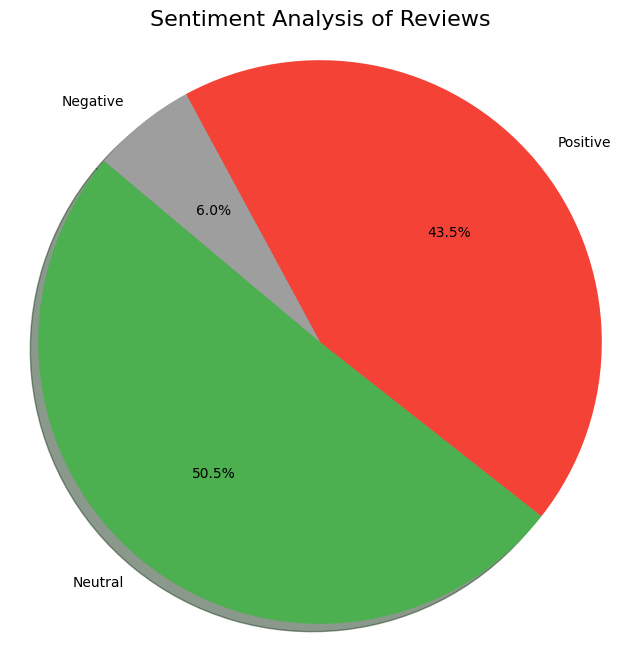

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
# This should be the name of the file you just created with the sentiment scores
input_file_name = 'reviews_with_sentiment.xlsx'
# This is the column we want to visualize
column_to_plot = 'sentiment_category'

try:
    # 1. Load the data from the Excel file
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # 2. Count the occurrences of each sentiment category
    # The .value_counts() method does this for us and is perfect for plotting
    sentiment_counts = df[column_to_plot].value_counts()
    print("\nCounts of each sentiment category:")
    print(sentiment_counts)

    # --- 3. Create the Pie Chart ---

    # Set the figure size for better readability
    plt.figure(figsize=(8, 8))

    # Define custom colors to make the chart more intuitive
    colors = ['#4CAF50', '#F44336', '#9E9E9E'] # Green for Positive, Red for Negative, Grey for Neutral

    # Create the pie chart with labels, percentages, and custom colors
    plt.pie(sentiment_counts,
            labels=sentiment_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=colors,
            shadow=True)

    # Add a title to the chart
    plt.title('Sentiment Analysis of Reviews', fontsize=16)

    # Ensure the pie chart is a circle
    plt.axis('equal')

    # Display the chart
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_file_name}' was not found. Please ensure the file name is correct and it's in the same directory.")
except KeyError:
    print(f"Error: The column '{column_to_plot}' was not found in the file. Please check the column names in your Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded 'reviews_with_sentiment.xlsx'.
Running topic modeling...
Topic modeling complete. Generating charts...


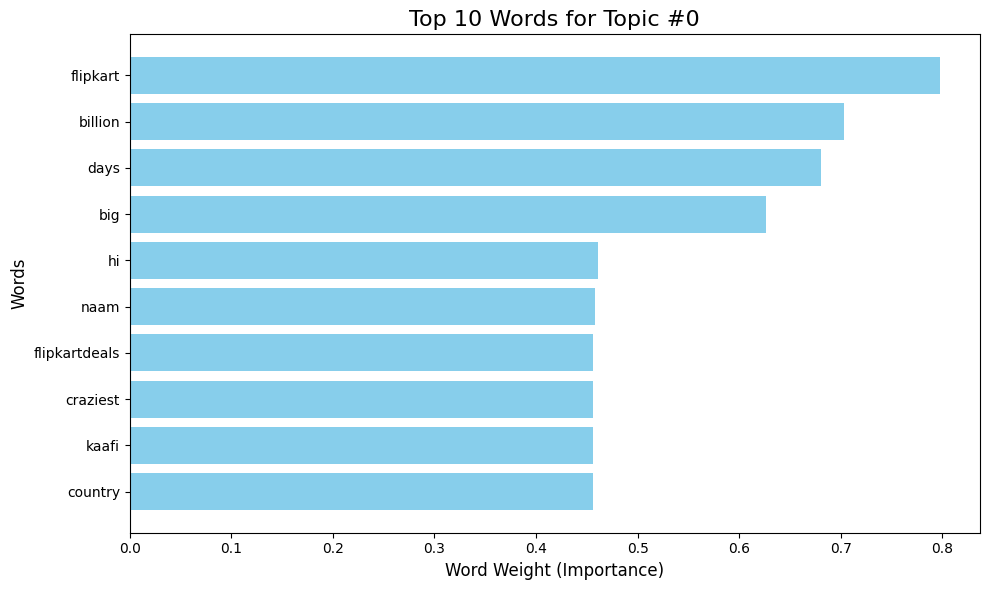

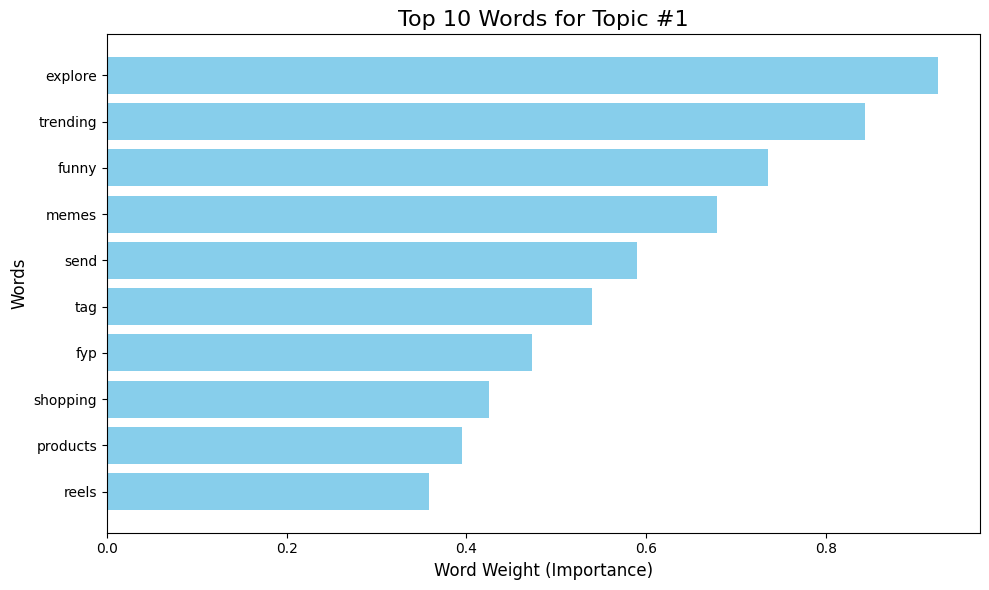

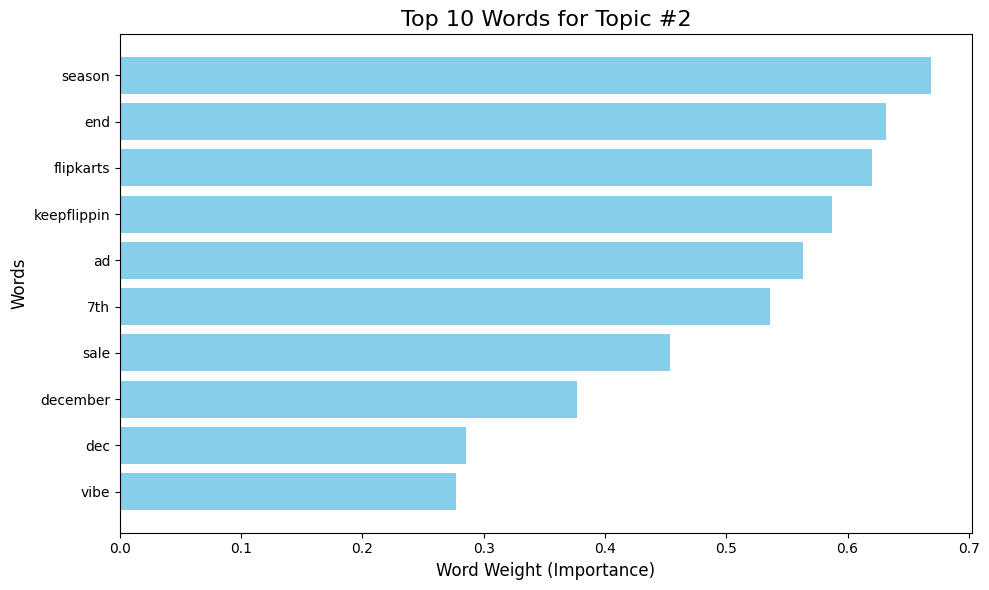

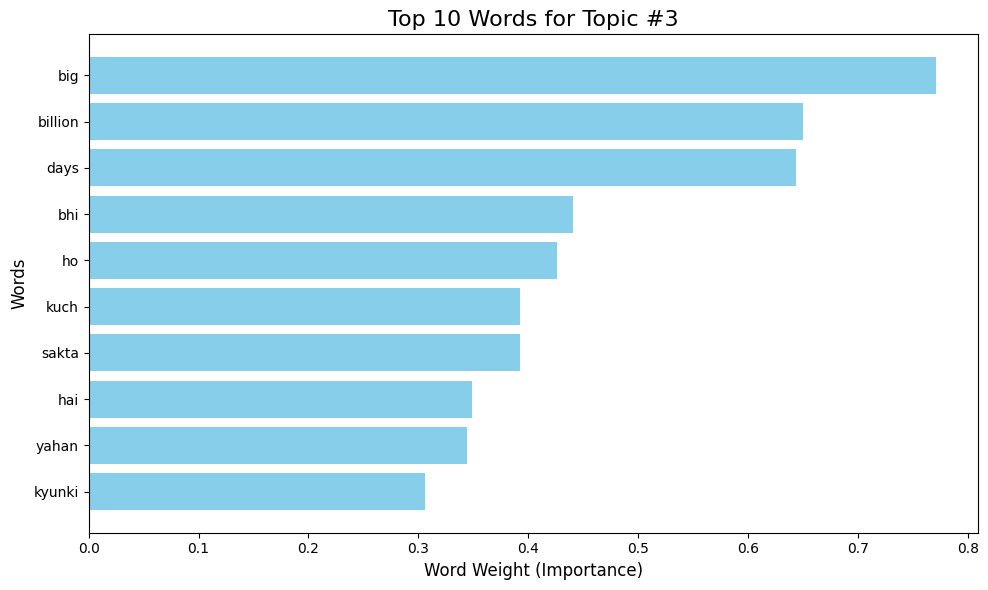

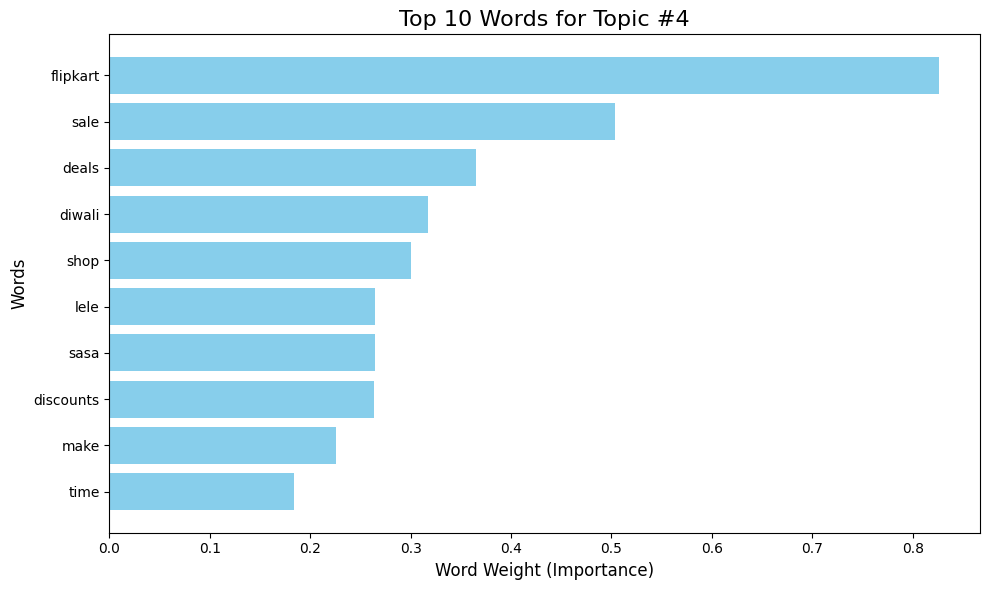

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- Step 1: Configuration ---
# This MUST be the exact name of your Excel file with sentiment data.
input_file_name = 'reviews_with_sentiment.xlsx'

# This MUST be the exact name of the column with cleaned text.
column_to_analyze = 'caption_no_stopwords_str'

# The number of topics and top words to display in the charts.
num_topics = 5
num_top_words = 10


try:
    # --- Step 2: Load and Prepare Data ---
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # Validate and clean the data
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")
    df.dropna(subset=[column_to_analyze], inplace=True)
    text_data = df[column_to_analyze].astype(str)
    if text_data.empty:
        raise ValueError("The text data is empty after cleaning. Cannot proceed.")

    # --- Step 3: Vectorize and Run NMF (same as before) ---
    print("Running topic modeling...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda').fit(tfidf_matrix)
    print("Topic modeling complete. Generating charts...")

    # --- Step 4: Generate a Bar Chart for Each Topic ---
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Get the indices of the top words for this topic
        top_word_indices = topic.argsort()[:-num_top_words - 1:-1]

        # Get the top words and their corresponding weights
        top_words = [tfidf_feature_names[i] for i in top_word_indices]
        top_weights = [topic[i] for i in top_word_indices]

        # --- Create the plot ---
        plt.figure(figsize=(10, 6)) # Set the figure size
        
        # Create a horizontal bar chart
        plt.barh(top_words, top_weights, color='skyblue')
        
        # Invert the y-axis so the most important word is at the top
        plt.gca().invert_yaxis()

        # Add titles and labels for clarity
        plt.title(f'Top {num_top_words} Words for Topic #{topic_idx}', fontsize=16)
        plt.xlabel('Word Weight (Importance)', fontsize=12)
        plt.ylabel('Words', fontsize=12)
        
        # Ensure the layout is tight so labels don't get cut off
        plt.tight_layout()
        
        # Display the plot
        plt.show()


except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("\nHere are the actual column names in your file:")
    print(pd.read_excel(input_file_name).columns.tolist())
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'reviews_with_sentiment.xlsx'.
Running topic modeling...
Topic modeling complete. Generating word clouds...


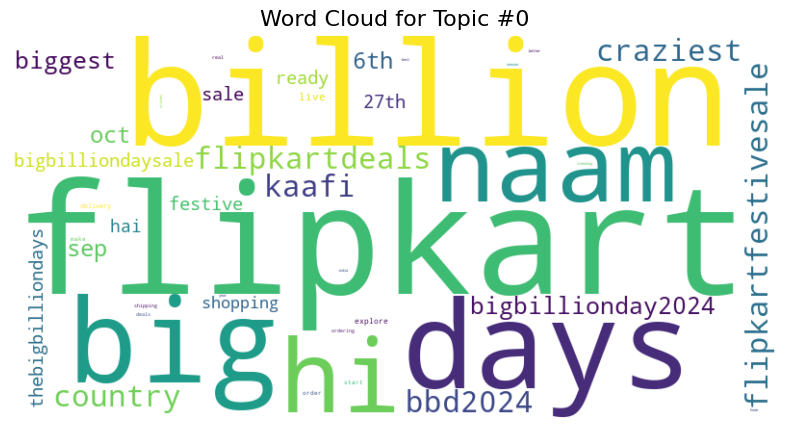

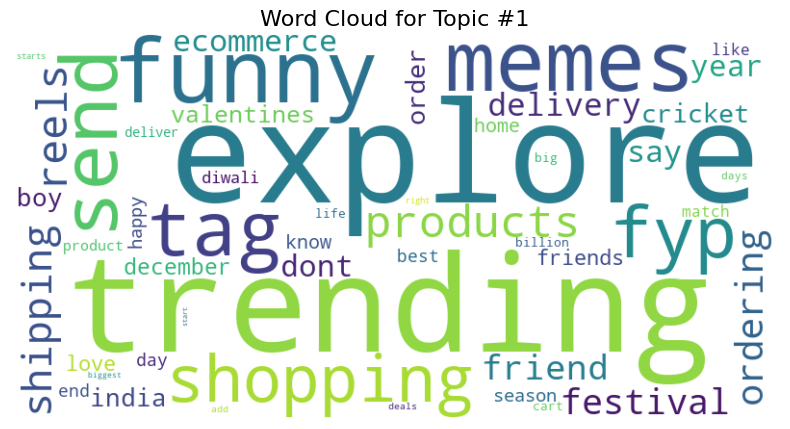

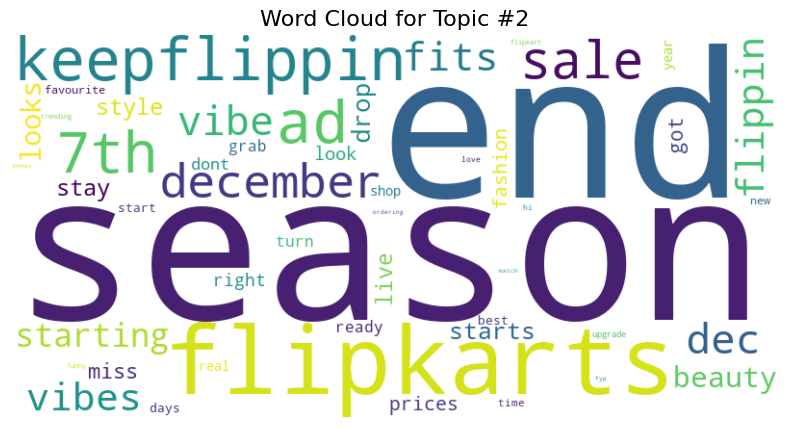

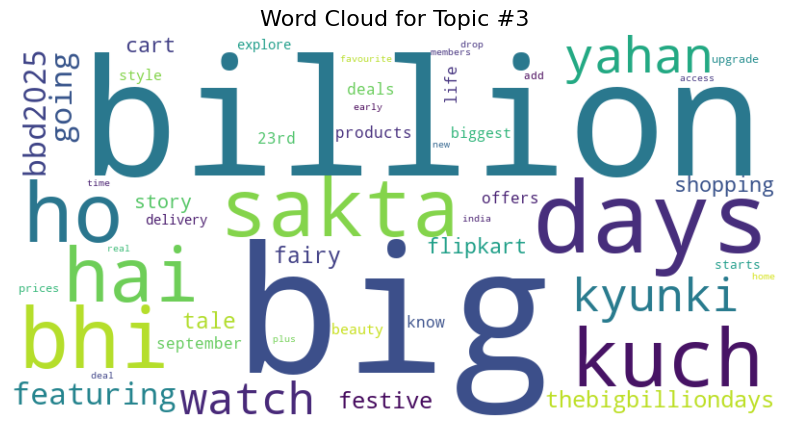

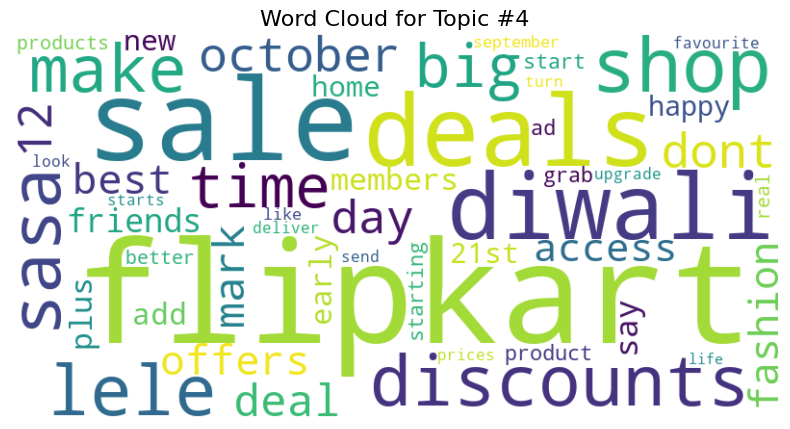

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# --- Step 1: Configuration ---
# This MUST be the exact name of your Excel file with sentiment data.
input_file_name = 'reviews_with_sentiment.xlsx'

# This MUST be the exact name of the column with cleaned text.
column_to_analyze = 'caption_no_stopwords_str'

# The number of topics you want to find.
num_topics = 5


try:
    # --- Step 2: Load and Prepare Data ---
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # Validate and clean the data
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")
    df.dropna(subset=[column_to_analyze], inplace=True)
    text_data = df[column_to_analyze].astype(str)
    if text_data.empty:
        raise ValueError("The text data is empty after cleaning. Cannot proceed.")

    # --- Step 3: Vectorize and Run NMF (same as before) ---
    print("Running topic modeling...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda').fit(tfidf_matrix)
    print("Topic modeling complete. Generating word clouds...")

    # --- Step 4: Generate a Word Cloud for Each Topic ---

    # Get the vocabulary (list of words) from the vectorizer
    words = tfidf_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(nmf_model.components_):
        # Create a dictionary of words and their weights for the current topic
        # The WordCloud object expects frequencies, so we'll use the NMF component weights
        topic_words = {words[i]: topic[i] for i in topic.argsort()[:-51:-1]} # Get top 50 words

        # Create the WordCloud object
        wordcloud = WordCloud(width=800,
                              height=400,
                              background_color='white',
                              colormap='viridis').generate_from_frequencies(topic_words)

        # --- Plot the Word Cloud ---
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Topic #{topic_idx}', fontsize=16)
        plt.axis('off') # Hide the axes
        plt.show()


except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("\nHere are the actual column names in your file:")
    print(pd.read_excel(input_file_name).columns.tolist())
except Exception as e:
    print(f"An unexpected error occurred: {e}")